# [5.2 Parameter Management](https://d2l.ai/chapter_deep-learning-computation/parameters.html)

In [1]:
import torch
from torch import nn

import matplotlib.pyplot as plt
%matplotlib inline

net = nn.Sequential(nn.Linear(4, 8), nn.ReLU(), nn.Linear(8, 1))
X = torch.rand(size=(2, 4))
net(X)

tensor([[-0.1939],
        [-0.3060]], grad_fn=<AddmmBackward>)

## 1. Parameter Access

- The [Parameter](https://pytorch.org/docs/stable/generated/torch.nn.parameter.Parameter.html) class: `torch.nn.parameter.Parameter`.

In [2]:
net[2].state_dict()

OrderedDict([('weight',
              tensor([[-0.2807, -0.1246, -0.3196,  0.0632, -0.2723, -0.0222,  0.2530,  0.3506]])),
             ('bias', tensor([-0.1732]))])

In [3]:
type(net[2].bias)

torch.nn.parameter.Parameter

In [4]:
net[0].weight.shape

torch.Size([8, 4])

In [5]:
net[2].bias

Parameter containing:
tensor([-0.1732], requires_grad=True)

In [6]:
# Access the tensor object stored in the net[2].bias parameter.
print(type(net[2].bias.data))
print(net[2].bias.data)

#     Another way of access the bias tensor stored in the 2nd layer of the network
print(net.state_dict()['2.bias'].data)

<class 'torch.Tensor'>
tensor([-0.1732])
tensor([-0.1732])


#### Access gradient

In [7]:
# access the gradient in the net[2].bias
# since we haven't run backpropagation for this network yet, it is in its initial state.
net[2].bias.grad == None

True

#### Access all parameters at once

In [8]:
# access parameters in the 1st layer of network
print(*[(name, param.shape) for name, param in net[0].named_parameters()])

('weight', torch.Size([8, 4])) ('bias', torch.Size([8]))


In [9]:
# access parameters in the entire network
print(*[(name, param.shape) for name, param in net.named_parameters()])

('0.weight', torch.Size([8, 4])) ('0.bias', torch.Size([8])) ('2.weight', torch.Size([1, 8])) ('2.bias', torch.Size([1]))


#### Count number of trainable parameters

In [10]:
# 4*8+8 + 8*1+1 = 49
print('TOTAL  :', sum(param.numel() for param in net.parameters() if param.requires_grad))    

TOTAL  : 49


### Collecting Parameters from Nested Blocks

In [11]:
def block1():
    return nn.Sequential(nn.Linear(4, 8), nn.ReLU(),
                         nn.Linear(8, 4), nn.ReLU())

def block2():
    net = nn.Sequential()
    for i in range(4):
        # Nested here
        net.add_module(f'block {i}', block1())
    return net

rgnet = nn.Sequential(block2(), nn.Linear(4, 1))
rgnet(X)

tensor([[-0.1392],
        [-0.1392]], grad_fn=<AddmmBackward>)

#### Check how the parameters are organized in the network

In [12]:
rgnet

Sequential(
  (0): Sequential(
    (block 0): Sequential(
      (0): Linear(in_features=4, out_features=8, bias=True)
      (1): ReLU()
      (2): Linear(in_features=8, out_features=4, bias=True)
      (3): ReLU()
    )
    (block 1): Sequential(
      (0): Linear(in_features=4, out_features=8, bias=True)
      (1): ReLU()
      (2): Linear(in_features=8, out_features=4, bias=True)
      (3): ReLU()
    )
    (block 2): Sequential(
      (0): Linear(in_features=4, out_features=8, bias=True)
      (1): ReLU()
      (2): Linear(in_features=8, out_features=4, bias=True)
      (3): ReLU()
    )
    (block 3): Sequential(
      (0): Linear(in_features=4, out_features=8, bias=True)
      (1): ReLU()
      (2): Linear(in_features=8, out_features=4, bias=True)
      (3): ReLU()
    )
  )
  (1): Linear(in_features=4, out_features=1, bias=True)
)

- The layers are hierarchically nested, we can also access them as though indexing through nested lists.

In [13]:
# e.g. access the 1st major block, within it the 2nd sub-block, and within that the bias of the 1st layer
rgnet[0][1][0].bias.data

tensor([ 0.3257,  0.4952, -0.3786, -0.3917, -0.4979,  0.1154, -0.3498, -0.0417])

## 2. Parameter Initialization

### Default Initialization in Pytorch

- By default, `nn.Linear` initialize parameters **uniformly** in the range (-``bound``, ``bound``), where ``bound`` = **Number of input dimensions**.
- Let's ask a wide linear layer and check : 

In [14]:
# The network would have 100x6000 parameters in stored and the weight parameter, 
#                        and 6000 parameters stored in bias.
net = nn.Linear(in_features=100, out_features=6000)

weight0 = net.weight.data.numpy()
print('weight dimension : ', weight0.shape)

bias0 = net.bias.data.numpy()
print('bias dimension : ',bias0.shape)

weight dimension :  (6000, 100)
bias dimension :  (6000,)


(array([59954., 60615., 60032., 60073., 59992., 59887., 59926., 60029.,
        59912., 59580.]),
 array([-1.0000000e-01, -8.0000073e-02, -6.0000151e-02, -4.0000223e-02,
        -2.0000298e-02, -3.7252903e-07,  1.9999553e-02,  3.9999478e-02,
         5.9999406e-02,  7.9999328e-02,  9.9999256e-02], dtype=float32),
 <a list of 10 Patch objects>)

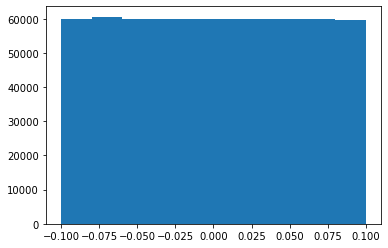

In [15]:
# By default bound = 1./sqrt(100) = 0.1
plt.hist(weight0.flatten())

(array([604., 599., 585., 556., 620., 613., 598., 589., 620., 616.]),
 array([-9.9936448e-02, -7.9949804e-02, -5.9963152e-02, -3.9976507e-02,
        -1.9989859e-02, -3.2112002e-06,  1.9983437e-02,  3.9970085e-02,
         5.9956729e-02,  7.9943381e-02,  9.9930026e-02], dtype=float32),
 <a list of 10 Patch objects>)

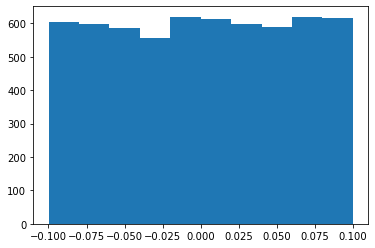

In [16]:
plt.hist(bias0.flatten())

### Built-in Initialization

1. Define init_function using the functions from `nn.init`

- `nn.init.normal_` 
- `nn.init.zeros_`
- `nn.init.constant_` 
- `nn.init.xavier_uniform_`

2. Use `net.apply(init_funciton)` to apply the `init_function` on network parameters

In [17]:
def init_normal(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, mean=0, std=0.01)
        nn.init.zeros_(m.bias)

net = nn.Sequential(nn.Linear(4, 8), nn.ReLU(), nn.Linear(8, 1))
net.apply(init_normal)
net[0].weight.data[0], net[0].bias.data[0]

(tensor([-0.0089, -0.0202, -0.0179, -0.0015]), tensor(0.))

In [18]:
def init_constant(m):
    if type(m) == nn.Linear:
        nn.init.constant_(m.weight, 1)
        nn.init.zeros_(m.bias)
net.apply(init_constant)
net[0].weight.data[0], net[0].bias.data[0]

(tensor([1., 1., 1., 1.]), tensor(0.))

In [19]:
def xavier(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)
def init_42(m):
    if type(m) == nn.Linear:
        nn.init.constant_(m.weight, 42)

net[0].apply(xavier)
net[2].apply(init_42)
print(net[0].weight.data[0])
print(net[2].weight.data)

tensor([-0.5887, -0.3713,  0.1250, -0.0319])
tensor([[42., 42., 42., 42., 42., 42., 42., 42.]])


#### More complicated combinations of inits

In [20]:
# w ~ U(  5, 10) ... 1/4 probability
# w ~      0     ... 1/2 probability
# w ~ U(-10, -5) ... 1/4 probability

def my_init(m):
    if type(m) == nn.Linear:
        print("Init", *[(name, param.shape)
                        for name, param in m.named_parameters()][0])
        nn.init.uniform_(m.weight, -10, 10)
        m.weight.data *= m.weight.data.abs() >= 5

net.apply(my_init)
net[0].weight[:2]

Init weight torch.Size([8, 4])
Init weight torch.Size([1, 8])


tensor([[ 0.0000,  9.4122,  0.0000,  0.0000],
        [-8.3178,  0.0000,  9.9160,  0.0000]], grad_fn=<SliceBackward>)

#### Setting parameter with specific array ID

In [21]:
net[0].weight.data[:] += 1
net[0].weight.data[0, 0] = 42
net[0].weight.data[0]

tensor([42.0000, 10.4122,  1.0000,  1.0000])

## 3. Tied Parameters

- In the example below, parameters of the second and third layer are tied. They are not just equal, they are represented by the same exact tensor. Thus, if we change one of the parameters, the other one changes, too. 
- When parameters are tied what happens to the gradients? Since the model parameters contain gradients, the gradients of the second hidden layer and the third hidden layer are added together during backpropagation.

In [22]:
# We need to give the shared layer a name so that we can refer to its
# parameters
shared = nn.Linear(8, 8)
net = nn.Sequential(nn.Linear(4, 8), nn.ReLU(),
                    shared, nn.ReLU(),
                    shared, nn.ReLU(),
                    nn.Linear(8, 1))
net(X)
# Check whether the parameters are the same
print(net[2].weight.data[0] == net[4].weight.data[0])
net[2].weight.data[0, 0] = 100
# Make sure that they are actually the same object rather than just having the
# same value
print(net[2].weight.data[0] == net[4].weight.data[0])

tensor([True, True, True, True, True, True, True, True])
tensor([True, True, True, True, True, True, True, True])
